In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from main import train

faster_rcnn = train()

Epoch 0: 100%|██████████| 313/313 [01:52<00:00,  2.77it/s, loss=67, rpn_cls_loss=0.158, rpn_reg_loss=1.29, rcnn_cls_loss=0.494, rcnn_reg_loss=5.34, accuracy=38.7, offsets=5.81]  


In [3]:
from lib.faster_rcnn_efficient import profiler

profiler.stats

defaultdict(int,
            {'forward_backbone': 18.022395587991923,
             'forward_rpn': 3.0781844149460085,
             'forward_nms': 4.634453737970034,
             'forward_roi_pooling': 2.8858392788970377,
             'forward_rcnn': 9.22561620191118})

In [4]:
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch import autograd, nn, optim, utils

from dataset_test import Dataset, color_map
from lib.predictor_efficient import FasterRCNNPredictor

dataset = Dataset(transforms.Compose([transforms.ToTensor()]), min_bboxes=3, max_bboxes=7)
dataloader = utils.data.DataLoader(dataset, batch_size=4, num_workers=12, shuffle=True)

dataloader_iter = iter(dataloader)

In [5]:
faster_rcnn_predictor = FasterRCNNPredictor(faster_rcnn).cuda()

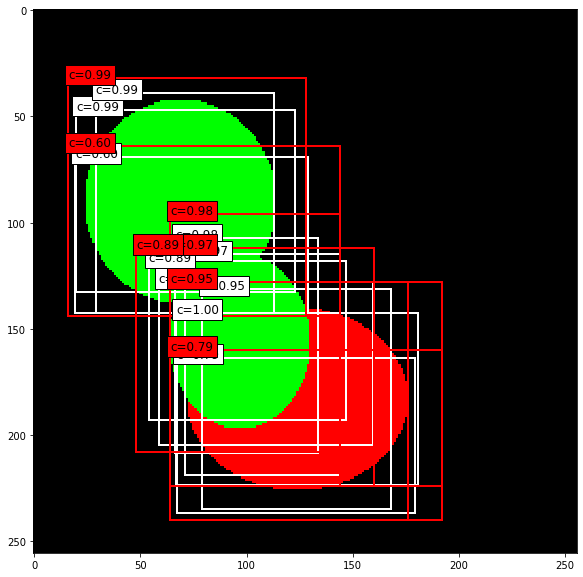

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch

from helper import visualize_anchors, visualize_rpn, visualize_rcnn, img_to_np

img, targets, classes = next(dataloader_iter)
img = img.float().cuda()
targets = targets.detach().float().cuda()
img_id = torch.arange(0, img.size()[0])

nms_reg_rounded, nms_reg, nms_cls, rcnn_reg, rcnn_cls, reg, cls = faster_rcnn_predictor(img)

i = 1

fig, ax = plt.subplots(figsize=(10, 10))
np_img = img_to_np(img[i])
ax.imshow(np_img)
visualize_rpn(ax, nms_reg.cpu()[i], nms_cls.cpu()[i], img.cpu()[i], [1.0, 1.0, 1.0], draw_all=False)
visualize_rpn(ax, nms_reg_rounded.cpu()[i], nms_cls.cpu()[i], img.cpu()[i], [1.0, 0, 0], draw_all=False)
plt.show()

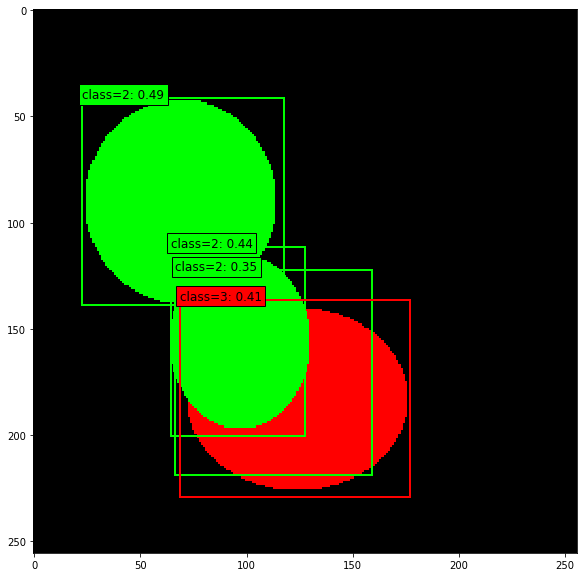

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
np_img = img_to_np(img[i])
ax.imshow(np_img)
visualize_rcnn(ax, reg[i].cpu(), cls[i].cpu(), color_map)
plt.show()